In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd

import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Model Implementation start

In [3]:
import pickle

In [4]:
with open('./pkl_files/enchanced/validation/en_val_data.pkl', 'rb') as f:
    val_img_arr = pickle.load(f)
with open('./pkl_files/enchanced/validation/en_val_data_age.pkl', 'rb') as f:
    val_bone_age_arr = pickle.load(f)
with open('./pkl_files/enchanced/validation/en_val_data_gender.pkl', 'rb') as f:
    val_gender_arr = pickle.load(f)

images_arr_val = np.array(val_img_arr)
bone_age_val = np.array(val_bone_age_arr)
gender_val = np.array(val_gender_arr)

In [5]:
with open('./pkl_files/enchanced/training/en_train_data.pkl', 'rb') as f:
    train_img_arr = pickle.load(f)
with open('./pkl_files/enchanced/training/en_train_data_age.pkl', 'rb') as f:
    train_bone_age_arr = pickle.load(f)
with open('./pkl_files/enchanced/training/en_train_data_gender.pkl', 'rb') as f:
    train_gender_arr = pickle.load(f)

images_arr_train = np.array(train_img_arr)
bone_age_train = np.array(train_bone_age_arr)
gender_train = np.array(train_gender_arr)

In [6]:
X_train = images_arr_train
X_val = images_arr_val
y_train = (bone_age_train-np.min(bone_age_train))/(np.max(bone_age_train)-np.min(bone_age_train))
y_val = (bone_age_val-np.min(bone_age_val))/(np.max(bone_age_val)-np.min(bone_age_val))
print("Training set: (",len(X_train),", ",len(y_train),")\n")
print("Validation set: (",len(X_val),", ",len(y_val),")\n")

Training set: ( 12611 ,  12611 )

Validation set: ( 1425 ,  1425 )


In [7]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.utils import plot_model

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
from keras.applications.inception_v3 import InceptionV3
import keras
from keras.applications.inception_v3 import preprocess_input

In [9]:
# Channel Attention Module
def channel_attention_module(x, ratio=8):

    batch,_,_,channel=x.shape
    # shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias= False)

    x1 = GlobalAveragePooling2D()(x)
    x1 = Flatten()(x1)
    x1 = l1(x1)
    x1 = l2(x1)

    x2 = GlobalMaxPooling2D()(x)
    x2 = Flatten()(x2)
    x2 = l1(x2)
    x2 = l2(x2)

    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x,feats])

    return feats

In [10]:
# spatical attention module

def spatial_attention_module(x):
    # Average Pooling
    x1 = tf.reduce_mean(x,axis = -1)
    x1 = tf.expand_dims(x1,axis = -1)

    # max pooling
    x2 = tf.reduce_max(x, axis = -1)
    x2 = tf.expand_dims(x2,axis=-1)

    feats = Concatenate()([x1,x2])

    feats = Conv2D(1,kernel_size=7, padding="same",activation="softmax")(feats)
    feats = Multiply()([x,feats])

    return feats

In [11]:
# Cbam module
def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)

    return x

In [12]:
def build_image_model():
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(299,299,3)
    )
    for layer in base_model.layers:
        layer.trainable = False
    x = cbam(base_model.output)

    x= GlobalAveragePooling2D()(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Model implementation End

In [17]:
model = build_image_model()

In [18]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_190 (Conv2D)            (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_190[0][0]']             
 Normalization)                 )                                                           

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae'])

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger

filepath = "saved_models/weights-improvement-{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='accuracy',verbose=1,save_best_only=True,mode ='min')
early_stop = EarlyStopping(monitor='mae',patience=5,verbose=1)
log_csv = CSVLogger('./csv_files/my_logs_30_epoch_final_5.csv',separator=',',append=False)

callbacks_list = [checkpoint, log_csv]

In [18]:
history = model.fit(
    X_train[:7000], y_train[:7000],
    epochs=10,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)

Epoch 1/10
874/875 [============================>.] - ETA: 0s - loss: 0.7026 - accuracy: 0.0016 - mae: 0.1507
Epoch 1: accuracy improved from inf to 0.00157, saving model to saved_models\weights-improvement-01-0.00.hdf5
875/875 [==============================] - 65s 59ms/step - loss: 0.7025 - accuracy: 0.0016 - mae: 0.1506 - val_loss: 0.6669 - val_accuracy: 0.0028 - val_mae: 0.1218
Epoch 2/10
874/875 [============================>.] - ETA: 0s - loss: 0.6999 - accuracy: 0.0016 - mae: 0.1494
Epoch 2: accuracy did not improve from 0.00157
875/875 [==============================] - 49s 56ms/step - loss: 0.7001 - accuracy: 0.0016 - mae: 0.1496 - val_loss: 0.7710 - val_accuracy: 0.0021 - val_mae: 0.2037
Epoch 3/10
875/875 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.0017 - mae: 0.1498
Epoch 3: accuracy did not improve from 0.00157
875/875 [==============================] - 49s 56ms/step - loss: 0.6992 - accuracy: 0.0017 - mae: 0.1498 - val_loss: 0.7116 - val_accura

In [14]:
#model.load_weights('./saved_weights/best_final_5.h5')


In [19]:
# Run this line only once
heatmap_model = Model(inputs=model.inputs, outputs=model.layers[-3].output)


In [20]:
img_input = X_train[0]
i = preprocess_input(img_input)
img= np.expand_dims(i, axis=0)
p1 = heatmap_model.predict(img)


1/1 [==============================] - 1s 931ms/step


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def produce_heatmap(cbam_output):
    heatmap = np.sum(cbam_output, axis=-1)
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    upsampled_heatmap = cv2.resize(heatmap, (299, 299))
    return upsampled_heatmap


In [22]:
heatmap= produce_heatmap(np.array(p1[0]))


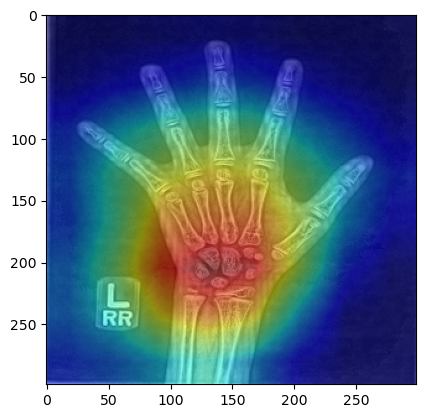

In [23]:
fig, ax = plt.subplots()
ax.imshow(img_input)
ax.imshow(heatmap, cmap='jet', alpha=0.5)
plt.show()

In [65]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:
def get_bounding_box(heatmap, threshold=0.8):
    binary_mask = (heatmap > threshold).astype(np.uint8)
    non_zero_indices = np.nonzero(binary_mask)
    if len(non_zero_indices[0]) == 0 or len(non_zero_indices[1]) == 0:
        return None
    min_row, min_col = np.min(non_zero_indices[0]), np.min(non_zero_indices[1])
    max_row, max_col = np.max(non_zero_indices[0]), np.max(non_zero_indices[1])

    bounding_box =  {
        'min_row': min_row,
        'min_col': min_col,
        'max_row': max_row,
        'max_col': max_col
    }
    return bounding_box

In [20]:

bounding_box = get_bounding_box(heatmap)

In [21]:
print(bounding_box)

{'min_row': 159, 'min_col': 88, 'max_row': 237, 'max_col': 181}


In [22]:
def crop_image_by_bounding_box(image, bounding_box):
    min_row, min_col = bounding_box['min_row'], bounding_box['min_col']
    max_row, max_col = bounding_box['max_row'], bounding_box['max_col']

    cropped_image = image[min_row:max_row + 1, min_col:max_col + 1, :]

    return cropped_image

In [23]:
cropped_image = crop_image_by_bounding_box(img_input, bounding_box)

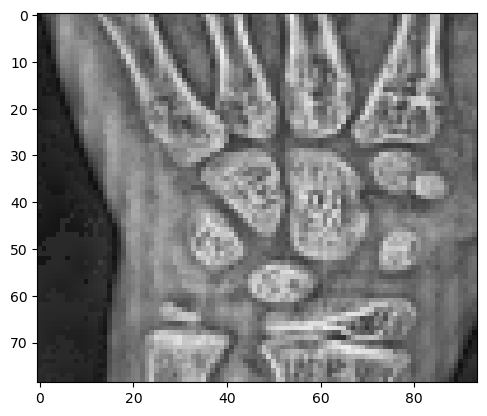

In [24]:

plt.imshow(cropped_image)

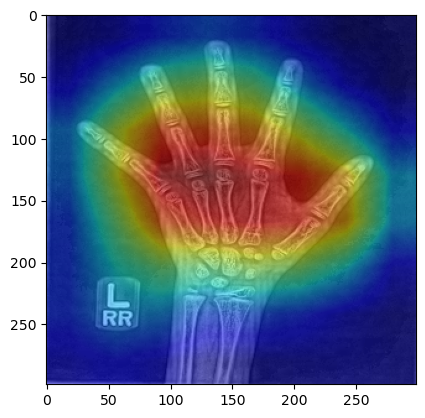

In [43]:
fig, ax = plt.subplots()
ax.imshow(roi_extractor.img)
ax.imshow(roi_extractor.heatmap_2, cmap='jet', alpha=0.5)
plt.show()